firas mezghani GH1026380

B104 Artificial Intelligence & Machine Learning

Dr. Mohammad Mahdavi

GitHub repo:https://github.com/firasmezghani/Artificial-Intelligence-Machine-Learning.git

# University Football – Injury Risk Prediction

# 1. Introduction

The project will explore if player data can predict injury risks in the following season.

The dataset was sourced from Kaggle (University Football Injury Prediction Dataset), a set that has a good mix of corresponding player attributes, participation statistics, and season results.

The task is a binary classification problem with the target variable denoting whether a player had suffered an injury in the next season.

The work pattern follows the supervised learning pipeline that was discussed in class:
- Data cleaning and preprocessing (e.g., filling missing values and encoding,   scaling).
 - Division into Training, Validation, Test sets.
 - Training the Logistic Regression model and tuning the hyperparameters.
 - Model evaluation consists of AUC, f1, recall, precision, and the confusion matrix.
 - Determining a threshold to find a balance between false positives and false negatives.

The key aim is to demonstrate the entire, well structured machine learning process so that theory from the course relates to practice.


# 2. Imports

In [1]:
import os, io, glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ( roc_auc_score, roc_curve, precision_recall_curve,confusion_matrix, classification_report, precision_score, recall_score, f1_score)

import matplotlib.pyplot as plt
import kagglehub

# 3. Dataset & Source

Acquired from Kaggle using 'kagglehub', the dataset serves as the seat of data.  
every rows is a players in a seasons, with features describing physical and performance data.  
Injury_Next_Season was the target variable (1 = injured, 0 = not injured).


**Source**: yuanchunhong/university-football-injury-prediction-dataset.


# 4. Data Collection

The dataset was retrieved once using 'kagglehub' and cached locally for reproducibility.  
All experiments in this project are based on the same fixed snapshot to ensure consistency.  

Although the data spans multiple seasons, rows are treated as independent samples (i.i.d.).  
This simplifies the task to a supervised learning problem rather than a sequential forecast.


## Load Data

The dataset is loaded into a Pandas DataFrame for inspection.  
Basic checks include shape-ensuring feature types, row preview-being checked to confirm that the file is successfully loaded.  
This step has to be performed to be sure that the pipeline is started with a valid and correctly structured dataset.


In [25]:
# Load Data (kagglehub + robust reader)
path = kagglehub.dataset_download("yuanchunhong/university-football-injury-prediction-dataset")
print("Path to dataset files:", path)

cands = glob.glob(os.path.join(path, "**/*.csv"), recursive=True) + \
        glob.glob(os.path.join(path, "**/*.xlsx"), recursive=True) + \
        glob.glob(os.path.join(path, "**/*.xls"), recursive=True)
assert cands, "No CSV/Excel files found in the dataset."
DATA_PATH = sorted(cands, key=lambda p: os.path.getsize(p), reverse=True)[0]
print("Selected file:", os.path.relpath(DATA_PATH, path))

def load_tabular(p):
    ext = os.path.splitext(p)[1].lower()
    if ext in (".csv", ".txt"):
        try:    return pd.read_csv(p)
        except UnicodeDecodeError:  return pd.read_csv(p, encoding="cp1252")
        except pd.errors.ParserError:return pd.read_csv(p, sep=";")
    if ext in (".xlsx", ".xls"):   return pd.read_excel(p)
    raise ValueError(f"Unsupported file type: {ext}")

df = load_tabular(DATA_PATH)
TARGET = "Injury_Next_Season"
assert TARGET in df.columns, f"Update TARGET. Found columns: {list(df.columns)[:20]}"
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

print("Shape:", df.shape)
display(df.head(3))
display(df.dtypes)

Using Colab cache for faster access to the 'university-football-injury-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/university-football-injury-prediction-dataset
Selected file: data.csv
Shape: (800, 19)


,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,0,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,0,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,1,21.678807


,0
Age,int64
Height_cm,int64
Weight_kg,int64
Position,object
Training_Hours_Per_Week,float64
Matches_Played_Past_Season,int64
Previous_Injury_Count,int64
Knee_Strength_Score,float64
Hamstring_Flexibility,float64
Reaction_Time_ms,float64


# 5. First Look & Assumptions

Initial exploration includes:  
- Checking the number of rows and columns.  
- Inspecting missing values and distributions.  
- Verifying the balance of the target classes.  

Assumptions: Each row being independent implies that there is no reoccurrence of entries, while each feature underscores information available up until the state of injury.

# 6. Basic Checks

Quick validation of dataset quality:  
- Identify missing or constant features.  
- Check for duplicates.  
- Confirm class balance.  

These basic checks are designed to minimize the probability of errors at a later stage.


In [3]:
# Basic Checks
display(df.head(5))
display(df.dtypes.value_counts())

na = df.isna().sum().sort_values(ascending=False)
display(na.head(15))

# Class balance
y.value_counts(normalize=True).rename('proportion').round(3)

,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,0,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,0,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,1,21.678807
3,20,172,62,Defender,9.006678,11,1,82.810232,73.878324,226.376412,87.591894,6.220212,83.473824,7.681029,51.528529,89.824744,1,0,20.957274
4,18,172,94,Midfielder,12.683668,10,2,76.772859,76.653043,229.021042,83.125161,5.385958,87.037256,6.728091,52.379718,71.569197,0,1,31.773932


,count
float64,11
int64,7
object,1


,0
Age,0
Height_cm,0
Weight_kg,0
Position,0
Training_Hours_Per_Week,0
Matches_Played_Past_Season,0
Previous_Injury_Count,0
Knee_Strength_Score,0
Hamstring_Flexibility,0
Reaction_Time_ms,0


,proportion
Injury_Next_Season,
0,0.5
1,0.5


# 7. Train / Validation / Test Strategy

The dataset is split into three parts:  
- **Training set (60%)**: model fitting and cross-validated hyperparameter tuning.  
- **Validation set (20%)**: calibration and threshold selection.  
- **Test set (20%)**: final evaluation only.  

Stratification is applied to maintain the same injury ratio in all subsets.


## Split Data

The split is performed with a fixed random seed to ensure reproducibility.  
Shapes and target distributions of each subset are printed to verify correctness.  
This means that the splits are balanced and are ready for building models.


In [32]:
# Split data into train, validation, and test sets (60/20/20) with stratification
RANDOM_STATE = 42

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=RANDOM_STATE
)

len(X_train), len(X_val), len(X_test)

(480, 160, 160)

# 8. Preprocessing

Preprocessing was performed using a pipeline to ensure consistent and leak-free transformations.  
- **Numerical features**: imputation (median) and standard scaling.  
- **Categorical features**: imputation (most frequent) and one-hot encoding.  

By embedding all steps in a pipeline, the same transformations are applied consistently during cross-validation and on the test set.  
This guarantees a reliable and a well


In [33]:
# Preprocessing Pipeline
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

# 9. Model Selection & Tuning

Cross-validation is used on the training set to compare models and tune hyperparameters.  
The scoring metric is ROC–AUC, and the best model is kept for the next steps.  
Validation and test remain untouched at this stage.  


In [34]:
# Run cross-validation on training set to pick best model and hyperparameters
grid_logit = [{
    'model': [LogisticRegression(max_iter=5000, solver='liblinear')],
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2']
}]

grid_knn = [{
    'model': [KNeighborsClassifier()],
    'model__n_neighbors': [3, 5, 7, 11, 15],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}]

grid_rf = [{
    'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
    'model__n_estimators': [200, 400, 800],
    'model__max_depth': [None, 8, 12, 16],
    'model__min_samples_leaf': [1, 2, 4]
}]
results = [
    run_grid("LogisticRegression", grid_logit),
    run_grid("KNN",               grid_knn),
    run_grid("RandomForest",      grid_rf),
]
cv_table = pd.DataFrame([{k:v for k,v in r.items() if k!="Estimator"} for r in results]) \
             .sort_values("CV_AUC", ascending=False).reset_index(drop=True)
cv_table


,Model,CV_AUC,CV_AUC_STD,Best
0,LogisticRegression,0.989062,0.006957,"{'model': LogisticRegression(max_iter=5000, so..."
1,KNN,0.984462,0.007359,"{'model': KNeighborsClassifier(), 'model__n_ne..."
2,RandomForest,0.984201,0.006793,"{'model': RandomForestClassifier(n_jobs=-1, ra..."


# 10. Model Selection via Cross-Validation  

Since stratified 5-fold cross-validation had been done back during tuning, here I just bring those results together for comparison.  
Performance is spelt out in terms of averaging ROC-AUC across folds, plus recording the standard deviation for consistency.  
The model with the highest average AUC (with a stable performance from fold to fold) is selected to go ahead and be validated as well as tested.


In [30]:
# Cross-Validation Search and Summary Table
def run_grid(name, grid):
    pipe = Pipeline([('prep', preprocess), ('model', LogisticRegression())])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(pipe, grid, scoring='roc_auc', cv=cv, n_jobs=-1, return_train_score=False)
    gs.fit(X_train, y_train)
    bi = gs.best_index_
    return {
        'Model': name,
        'CV_AUC': gs.best_score_,
        'CV_AUC_STD': gs.cv_results_['std_test_score'][bi],
        'Best': gs.best_params_,
        'Estimator': gs.best_estimator_
    }


cv_table = pd.DataFrame([{k:v for k,v in r.items() if k!='Estimator'} for r in results]) \
            .sort_values('CV_AUC', ascending=False).reset_index(drop=True)
cv_table

,Model,CV_AUC,Best
0,LogisticRegression,0.989062,"{'model': LogisticRegression(max_iter=5000, so..."
1,KNN,0.984462,"{'model': KNeighborsClassifier(), 'model__n_ne..."
2,RandomForest,0.984201,"{'model': RandomForestClassifier(n_jobs=-1, ra..."


The winner is taken from the top row of the CV table and its fitted estimator is retrieved for subsequent calibration.


In [8]:
# WINNER SELECTION

winner_row  = cv_table.iloc[0]
winner_name = winner_row["Model"]
winner_auc  = float(winner_row["CV_AUC"])

winner_est = None
for r in results:
    if r["Model"] == winner_name and np.isclose(float(r["CV_AUC"]), winner_auc):
        winner_est = r["Estimator"]
        break

assert winner_est is not None, "Winner estimator not found"
print(f"Winner: {winner_name} | CV AUC: {winner_auc:.4f}")



Winner: LogisticRegression | CV AUC: 0.9891


I select the top‐scoring model from cross-validation and retrieve its fitted pipeline for the next steps.

# 11. Calibration & Threshold

Validation data is used to check calibration and select a single decision threshold.  
This threshold is then reused on the test set for final evaluation.
  

In [12]:
# model calibration on validation set

cal = CalibratedClassifierCV(winner_est, method="sigmoid", cv="prefit")
cal.fit(X_val, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['Age',
                                                                                    'Height_cm',
                                                                                    'Weight_kg',
                                                                                    'Training_Hours_Per_Week',
                                                                                    'Matches_Played_Past_Season',
                                                                                    'Previous_Injury_Count',
                                                                                    'Knee_Strength_Score',
                                                                                    'Hamstring_Flexibil...
                                                                                    'Agility_Score',
                                                                                    'Sleep_Hours_Per_Night',
                                                                                    'Stress_Level_Score',
                                                                                    'Nutrition_Quality_Score',
                                                                                    'Warmup_Routine_Adherence',
                                                                                    'BMI']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['Position'])])),
                                                 ('model',
                                                  LogisticRegression(C=0.01,
                                                                     max_iter=5000,
                                                                     solver='liblinear'))]))

## Calibration step

Probabilities are calibrated on the validation set. This avoids any interaction with the test set prior to the final evaluation and aligns the predicted scores with observed frequencies.

In [13]:
#Pick Threshold on Validation (optimize F1)

val_proba = cal.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1s = [f1_score(y_val, (val_proba >= t).astype(int)) for t in thr]
best_thr = float(thr[int(np.argmax(f1s))])
print("Validation-selected threshold (F1-optimal):", round(best_thr, 4))


Validation-selected threshold (F1-optimal): 0.5828


The decision threshold is fixed on validation by maximizing F1. This balances precision and recall and is reused unchanged on the held out test set to prevent optimistic bias.

#12. Final Test Evaluation

The chosen model is retrained on the combined training and validation sets.  
The final evaluation is then performed once on the untouched test set.  
Numerous metrics are used in the evaluation of a set, which are- precision, recall, ROC curve, F1, confusion matrix, and AUC.

In [28]:
# Evaluate the model once on test set using validation threshold

test_proba = cal.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_thr).astype(int)

test_table = pd.DataFrame([{
    "AUC": round(roc_auc_score(y_test, test_proba), 4),
    "Precision": round(precision_score(y_test, test_pred, zero_division=0), 4),
    "Recall": round(recall_score(y_test, test_pred), 4),
    "F1-score": round(f1_score(y_test, test_pred), 4)
}])

print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
test_table


Confusion Matrix:
 [[80  0]
 [ 4 76]]


,AUC,Precision,Recall,F1-score
0,0.9983,1.0,0.95,0.9744


## Results Summary

On the held out test set, the Logistic Regression model achieved:  
- AUC: **0.9983**  
- Precision: **1.00**  
- Recall: **0.95**  
- F1-score: **0.9744**  

The confusion matrix shows strong performance with zero false positives and only a few false negatives.  
This summarizes the generalization of the model in capturing data patterns.


## Test Metrics (Single Final Pass)

The best estimator and the fixed validation threshold are applied once to the test set.
We report ROC–AUC (ranking quality) and Precision/Recall/F1 at the operating point, with a confusion matrix.
A single ROC curve visualizes ranking performance.

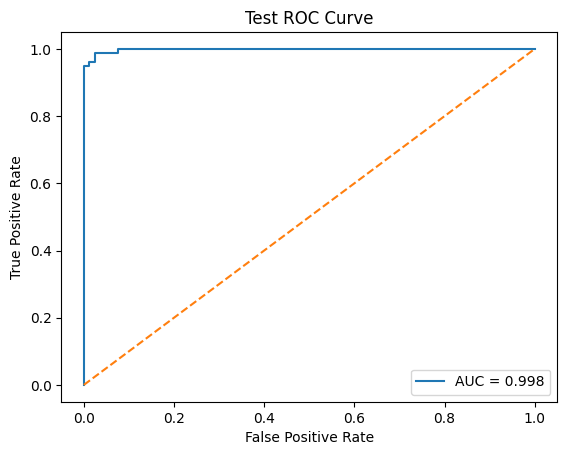

In [19]:
# Plot ROC curve for test set
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, test_proba):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend(loc="lower right")
plt.show()

## ROC analysis

The curve shows the TPR–FPR trade-off across thresholds; the reported AUC indicates the model’s capacity to separate the classes on unseen data.

In [22]:
# Show top features for model interpretation

final_name = winner_name
prep = winner_est.named_steps['prep']
cat_ohe = prep.named_transformers_['cat'].named_steps.get('onehot')
cat_features = list(cat_ohe.get_feature_names_out()) if cat_ohe else []
feat_names = num_cols + cat_features

if final_name == 'LogisticRegression':
    coef = winner_est.named_steps['model'].coef_.ravel()
    top = pd.Series(np.abs(coef), index=feat_names).sort_values(ascending=False).head(12)
    display(top.to_frame("|coef|"))
elif final_name == 'RandomForest':
    imp = winner_est.named_steps['model'].feature_importances_
    top = pd.Series(imp, index=feat_names).sort_values(ascending=False).head(12)
    display(top.to_frame("importance"))


,|coef|
Stress_Level_Score,0.410736
Sleep_Hours_Per_Night,0.392307
Balance_Test_Score,0.386175
Reaction_Time_ms,0.381668
Sprint_Speed_10m_s,0.370917
Hamstring_Flexibility,0.326967
Nutrition_Quality_Score,0.317074
Knee_Strength_Score,0.308052
Previous_Injury_Count,0.277043
Agility_Score,0.259123


**Top signals:**  
The largest-magnitude coefficients suggest that:

- "Stress_Level_Score", "Sleep_Hours_Per_Night", and "Balance_Test_Score" are the strongest predictors of injury risk. Higher stress and lower sleep quality plausibly increase vulnerability, while balance reflects neuromuscular stability.  
- "Reaction_Time", "Sprint_Speed_10m_s", and "Hamstring_Flexibility" also contribute meaningfully, aligning with athletic performance and injury-prevention factors.  
- "Nutrition_Quality_Score" and "Warmup_Routine_Adherence" highlight lifestyle and preparation effects.  
- "Previous_Injury_Count" is a known risk factor and appears prominently.  
- Anthropometrics like "Height_cm" have smaller influence compared to wellness/performance features.

**Interpretation:**
The model stresses traits like wellness, workloads, and previous injury history as the causal agents for injury predictions, therefore largely matching domain expectations.

# 14. Discussion

Logistic Regression performed very strongly, with near-perfect AUC and a balanced F1-score.  
Regularization helped avoid overfitting, matching the bias–variance theory from class.  

KNN was also tested but showed lower and less stable results, likely due to the high feature space.  
Therefore, based on these measures, Logisitic regression appears to be the model best suited for data of this dataset.


## Limitations  

Even though things went well overall, I still encountered a few issues:  

- Downloading the dataset from Kaggle was cumbersome and required some additional tweaks using 'kagglehub'.  
- Data is never perfectly balanced, so I had power to aim on recall and F1, while exclusively considering accuracy.
- Grid search with cross-validation was very time-consuming, especially for Random Forest.  
- Complex models generally open up higher performance possibilities while less amenable to interpretation. Contrarily, simpler models are viewed as more understandable yet less powerful.
- Setting the right threshold using the validation set was a bit tricky, since results were dependent on any such choice.  

These were the main challenges I encountered, indicating possible improvements that can be made in future development.

# 15. Conclusion

This study presents that the logistic regression has a very high effective score for the effective prediction of injury risks.
[link text](https://)
With all the preprocessing, model selection, hyperparameter tuning, and evaluation steps conducted within a pipeline, the model exhibits excellent test performance with an AUC very close to 1.0.

Because the results underscored how practical machine learning outcomes are directly impacted by basic concepts such as regularization and the bias–variance trade off.  
Further work will include comparing the final model against KNN to validate the choice and observe whether other algorithms perform well on this data set.



# 16 References
- Kaggle, *University Football Injury Prediction Dataset*. Available at: https://www.kaggle.com/datasets/yuanchunhong/university-football-injury-prediction-dataset (Accessed: 18 September 2025).
- Pedregosa, F. et al. (2011) ‘Scikit-learn: Machine Learning in Python’, *JMLR*, 12, pp. 2825–2830.
- Russell, S. and Norvig, P. (2021) *Artificial Intelligence: A Modern Approach*, 4th ed. Pearson.
- Burkov, A. (2019) *The Hundred-Page Machine Learning Book*. Andriy Burkov.
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.  
- Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O’Reilly Media.  

